In [206]:
import numpy as np, pandas as pd, sklearn as sk
DATASET = pd.read_csv("student_habits_performance.csv")
print(DATASET.head(3).T)

                                     0            1            2
student_id                       S1000        S1001        S1002
age                                 23           20           21
gender                          Female       Female         Male
study_hours_per_day                0.0          6.9          1.4
social_media_hours                 1.2          2.8          3.1
netflix_hours                      1.1          2.3          1.3
part_time_job                       No           No           No
attendance_percentage             85.0         97.3         94.8
sleep_hours                        8.0          4.6          8.0
diet_quality                      Fair         Good         Poor
exercise_frequency                   6            6            1
parental_education_level        Master  High School  High School
internet_quality               Average      Average         Poor
mental_health_rating                 8            8            1
extracurricular_participa

In [207]:
print("Пропусков:", DATASET.isna().sum())

Пропусков: student_id                        0
age                               0
gender                            0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


In [208]:
print("Доля строк с пропусками: ", f"{DATASET['parental_education_level'].isna().mean() * 100}%")

Доля строк с пропусками:  9.1%


In [209]:
DATASET.fillna({"parental_education_level": 'Unknown'}, inplace=True)
print("Пропусков сейчас: ", DATASET["parental_education_level"].isna().sum())

Пропусков сейчас:  0


In [210]:
def one_hot_encode(df, drop_first=True):
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'student_id' in categorical_cols:
        categorical_cols.remove('student_id')
    print("Категориальные признаки для OHE:", list(categorical_cols))
    
    
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df_encoded

DATASET_ENCODED = one_hot_encode(DATASET)
print("Размер до кодирования:", DATASET.shape)
print("Размер после кодирования:", DATASET_ENCODED.shape)
DATASET_ENCODED.head(3).T

Категориальные признаки для OHE: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
Размер до кодирования: (1000, 15)
Размер после кодирования: (1000, 20)


,0,1,2
student_id,S1000,S1001,S1002
age,23,20,21
social_media_hours,1.2,2.8,3.1
netflix_hours,1.1,2.3,1.3
attendance_percentage,85.0,97.3,94.8
sleep_hours,8.0,4.6,8.0
exercise_frequency,6,6,1
mental_health_rating,8,8,1
exam_score,56.2,100.0,34.3
gender_Male,False,False,True


In [211]:

X = DATASET_ENCODED.drop(columns=['student_id', 'exam_score'])
Y = DATASET_ENCODED['exam_score']

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=None)


In [213]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [214]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import pandas as pd

model_mse = SGDRegressor(loss='squared_error', max_iter=5000, tol=1e-3, random_state=None)
model_mse.fit(X_train_scaled, Y_train)
Y_pred_mse = model_mse.predict(X_test_scaled)

model_huber = SGDRegressor(loss='huber', max_iter=5000, tol=1e-3, random_state=None)
model_huber.fit(X_train_scaled, Y_train)
Y_pred_huber = model_huber.predict(X_test_scaled)

results = pd.DataFrame({
    'Model': ['MSE', 'Huber'],
    'MAPE (%)': [
        mean_absolute_percentage_error(Y_test, Y_pred_mse) * 100,
        mean_absolute_percentage_error(Y_test, Y_pred_huber) * 100
    ],
    'R²': [
        r2_score(Y_test, Y_pred_mse),
        r2_score(Y_test, Y_pred_huber)
    ]
})
print(results)

   Model   MAPE (%)        R²
0    MSE  19.800112  0.198491
1  Huber  26.894933 -0.803070


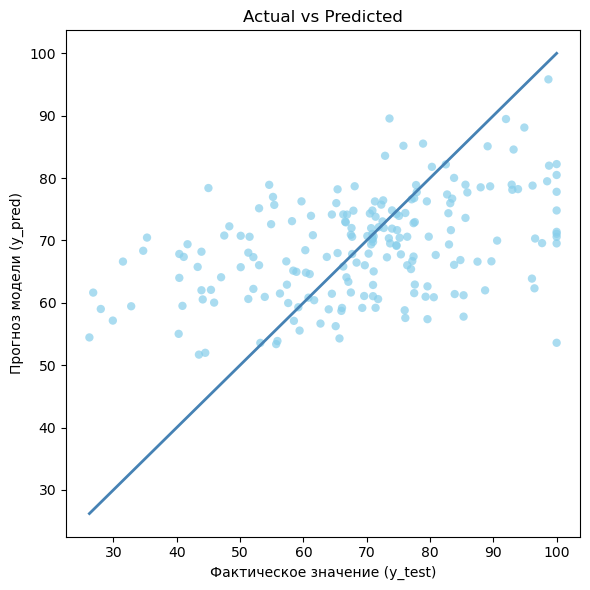

In [215]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
point_color = 'skyblue' 
line_color  = 'steelblue'

plt.scatter(Y_test, Y_pred_mse, alpha=0.7, color=point_color, edgecolors='none')
lim_min = float(min(np.min(Y_test), np.min(Y_pred_mse)))
lim_max = float(max(np.max(Y_test), np.max(Y_pred_mse)))
plt.plot([lim_min, lim_max], [lim_min, lim_max], color=line_color, linewidth=2)
plt.xlabel('Фактическое значение (y_test)')
plt.ylabel('Прогноз модели (y_pred)')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()


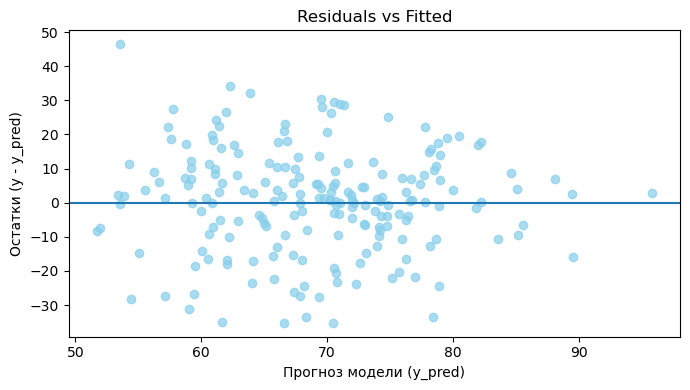

In [216]:
residuals = Y_test - Y_pred_mse

point_color = 'skyblue' 
line_color  = 'steelblue' 

plt.figure(figsize=(7,4))
plt.scatter(Y_pred_mse, residuals, alpha=0.7, color=point_color, edgecolors=None)
plt.axhline(0)
plt.xlabel('Прогноз модели (y_pred)')
plt.ylabel('Остатки (y - y_pred)')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

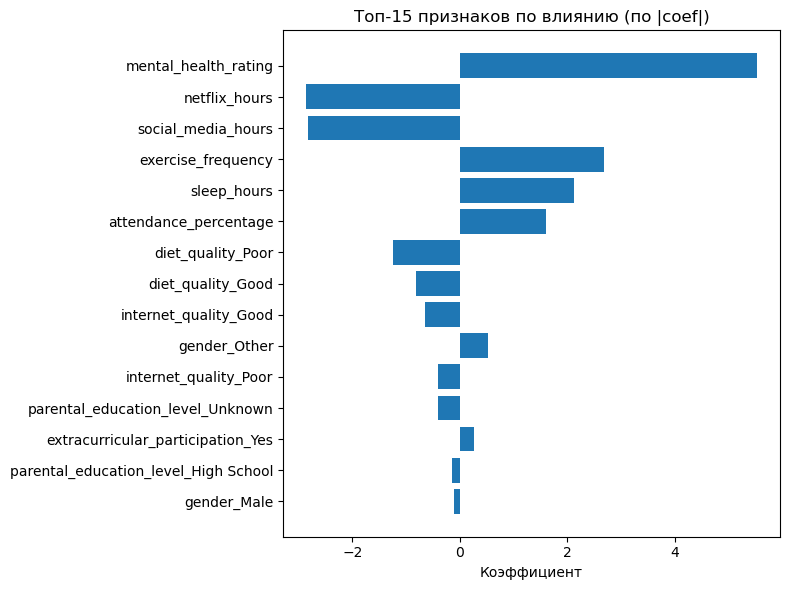

In [217]:
model_to_plot = model_mse  # или model_mse / model_cosh
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': model_to_plot.coef_
})
coef_df['abs_coef'] = coef_df['coef'].abs()
top = coef_df.sort_values('abs_coef', ascending=False).head(15)

plt.figure(figsize=(8, 6))
plt.barh(top['feature'][::-1], top['coef'][::-1])
plt.xlabel('Коэффициент')
plt.title('Топ-15 признаков по влиянию (по |coef|)')
plt.tight_layout()
plt.show()


In [218]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error, make_scorer
pipe_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', SGDRegressor(random_state=None, max_iter=5000, tol=1e-4))
])

param_grid_sgd = {
    'reg__loss': ['squared_error', 'huber'],
    'reg__penalty': ['l2', 'l1', 'elasticnet'],
    'reg__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'reg__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'reg__eta0': [0.001, 0.01, 0.05, 0.1],  # базовый шаг
}

cv = KFold(n_splits=5, shuffle=True, random_state=None)
gs_sgd = GridSearchCV(pipe_sgd, param_grid_sgd, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1, verbose=0)
gs_sgd.fit(X, Y)
best_sgd = gs_sgd.best_estimator_
best_sgd.fit(X_train, Y_train)
y_pred_best = best_sgd.predict(X_test)

print("Best SGD  Test R²:", r2_score(Y_test, y_pred_best))
print("Best SGD  MAPE % :", mean_absolute_percentage_error(Y_test, y_pred_best)*100)


Best SGD  Test R²: 0.2131198623682532
Best SGD  MAPE % : 19.759297873408812


In [219]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

cv = KFold(n_splits=5, shuffle=True, random_state=None)

def grid_lin(model, grid):
    pipe = Pipeline([('scaler', StandardScaler()), ('reg', model)])
    gs = GridSearchCV(pipe, grid, scoring='r2', cv=cv, n_jobs=-1)
    gs.fit(X, Y)
    return gs.best_estimator_

ridge_best = grid_lin(Ridge(random_state=None), {'reg__alpha':[0.01,0.1,1,10,100]})
lasso_best = grid_lin(Lasso(random_state=None, max_iter=20000), {'reg__alpha':[1e-4,1e-3,1e-2,1e-1,1,10]})
enet_best  = grid_lin(ElasticNet(random_state=None, max_iter=20000),
                      {'reg__alpha':[1e-4,1e-3,1e-2,1e-1,1],
                       'reg__l1_ratio':[0.2,0.5,0.8]})

cands = {'Best SGD': best_sgd, 'Ridge': ridge_best, 'Lasso': lasso_best, 'ElasticNet': enet_best}
rows = []
for name, est in cands.items():
    est.fit(X_train, Y_train)
    yp = est.predict(X_test)
    rows.append({'Model': name, 'R²': r2_score(Y_test, yp),
                 'MAPE (%)': mean_absolute_percentage_error(Y_test, yp)*100})
print(pd.DataFrame(rows).sort_values('R²', ascending=False).round(3))

        Model     R²  MAPE (%)
0    Best SGD  0.213    19.763
2       Lasso  0.202    19.743
3  ElasticNet  0.201    19.764
1       Ridge  0.196    19.816


In [220]:
from sklearn.preprocessing import PolynomialFeatures

poly_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),  
    ('reg', Ridge(random_state=None))
])

param_poly = {
    'poly__degree': [2],          
    'reg__alpha': [0.1, 1, 10, 100]
}

gs_poly = GridSearchCV(poly_pipe, param_poly, scoring='r2', cv=cv, n_jobs=-1)
gs_poly.fit(X, Y)

poly_best = gs_poly.best_estimator_
# Сравнение на тесте:
yp = poly_best.predict(X_test)
print("Poly2+Ridge Test R²:", r2_score(Y_test, yp), "| MAPE %:", mean_absolute_percentage_error(Y_test, yp)*100)


Poly2+Ridge Test R²: 0.368045410743461 | MAPE %: 17.77323731146757


In [221]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

hgb = HistGradientBoostingRegressor(random_state=None)
scores = cross_val_score(hgb, X, Y, scoring='r2', cv=5, n_jobs=-1)
print('HGB CV R² mean:', scores.mean().round(4))


HGB CV R² mean: -0.0232


In [222]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import Ridge
import numpy as np

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=None)

# Базовый бенчмарк: Poly(2)+Ridge, без лишних наворотов
bench = Pipeline([
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', Ridge(alpha=10.0, random_state=None))
])

def eval_model(name, est):
    scores = cross_val_score(est, X, Y, scoring='r2', cv=cv, n_jobs=-1)
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

eval_model("Bench Poly2+Ridge", bench)

# Вариант с Yeo-Johnson может быть лучше/хуже — проверяем честно тем же CV
yj_poly = Pipeline([
    ('pt', PowerTransformer(method='yeo-johnson')),
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', Ridge(alpha=10.0, random_state=None))
])
eval_model("YJ+Poly2+Ridge", yj_poly)


Bench Poly2+Ridge: mean=-0.0040, std=0.0707
YJ+Poly2+Ridge: mean=-0.0262, std=0.0770
